# Predict Future Sales

### Objective

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.



### File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

### Data fields

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

### Evaluation

Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.



### Aknowledgements

https://www.kaggle.com/c/competitive-data-science-predict-future-sales/

### Project findings

The main takeway from this project is that a good cross validation score when testing does not necessarily result in an accurate prediction on new data. A Root Mean Squared Error (RMSE) of 0.45 on the test set was not matched by a score of 1 when uploading prediction of the new data to kaggle, where it achieved a disappointing score of 1.04.

Considering the number of observations in the new set that have no history from which to predict, a stacked solution consisting of different prediction methods could be used to achieve a higher position on the leaderboard.



### Machine learning problem

Predicting a sales amount is a regression problem. This project compares different ensemble methods with hyperparameter tuning. Moreover, I considered the problem to be time-series sensitive and prepared the training data to reflect this.

### About me

As a data enthusiast, there was no formal computer science, mathematics, or statistics education for me. However, I value continuous learning and I hope that this machine learning project will showcase much of what I have learned through the Elite Data Science Machine Learning Accelerator course.

# Library imports

In [10]:
# numpy for computation
import numpy as np

# pandas for dataframes
import pandas as pd
pd.set_option('display.max_columns', 100)
#pd.set_option('float_format', '{:0f}'.format)

# matplotlib for visualization
from matplotlib import pyplot as plt
%matplotlib inline

# seaborn for easy visualization
import seaborn as sns
sns.set_style('darkgrid')

# pipeline
from sklearn.pipeline import make_pipeline

# algos
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# scaler
from sklearn.preprocessing import StandardScaler

# hyperparameter grid
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import mean_squared_error

# pickle to store model
import pickle as pickle

# 1. Load data

In [11]:
# sales_train.csv to dataframe
df_sales = pd.read_csv('data/sales_train.csv', parse_dates=['date'], dayfirst=True)

print(df_sales.shape)
df_sales.tail(3)

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935846,2015-10-14,33,25,7459,349.0,1.0
2935847,2015-10-22,33,25,7440,299.0,1.0
2935848,2015-10-03,33,25,7460,299.0,1.0


In [12]:
# test.csv to dataframe
df_test = pd.read_csv('data/test.csv')
print(df_test.shape)
df_test.head(3)

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [13]:
# shops.csv to dataframe
df_shop = pd.read_csv('data/shops.csv')
print(df_shop.shape)
df_shop.head(3)

(60, 2)


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [14]:
# items.csv to dataframe
df_item = pd.read_csv('data/items.csv')
print(df_item.shape)
df_item.head(3)

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [15]:
# item_categories.csv to dataframe
df_item_cat = pd.read_csv('data/item_categories.csv')
print(df_item_cat.shape)
df_item_cat.head(3)

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


# 2. Data exploration
This section will first take a look at what we are trying to predict through some hypothesis testing and some analysis of the train data set.

## 2.1 Data scope
_Are the shops and items present in the train set?_


In [16]:
# statistics
df_test[['shop_id', 'item_id']].astype('object').describe()

,shop_id,item_id
count,214200,214200
unique,42,5100
top,59,22167
freq,5100,42


In [17]:
df_test.item_id.value_counts()

2047     42
19744    42
15406    42
13359    42
3240     42
         ..
21086    42
21214    42
17244    42
21342    42
2049     42
Name: item_id, Length: 5100, dtype: int64

**_The test data contains observations for 42 shops and 5100 items._**

**_Each item has an oservation for each shop_.**

In [18]:
# statistics
df_sales[['shop_id', 'item_id']].astype('object').describe()

,shop_id,item_id
count,2935849,2935849
unique,60,21807
top,31,20949
freq,235636,31340


**_The training data contains more shops than the test data._**

**_These shops will be dropped before training the model to reduce noise._**

### 2.1.1 Hypothesis 1
The test set contains items that have never been purchased before

In [19]:
train_shops = df_sales.shop_id.unique()
test_shops = df_test.shop_id.unique()

train_items = df_sales.item_id.unique()
test_items = df_test.item_id.unique()

In [20]:
# check for missing training observations
new_items = sum([1 if i not in train_items else 0 for i in test_items])
print(new_items, 'items in the test data have no purchase history')

363 items in the test data have no purchase history


___TRUE: These items could be assumed to be new to market and classified as such___

___Or they could contain items that were end of life before 2013.___

### 2.1.2 Hypothesis 2
Not all shops buy all items

In [21]:
(
    df_sales
    .copy()[df_sales.item_id.isin(test_items)]
    .groupby('shop_id')
    .agg(n_unique_items = ('item_id', 'nunique'))
).describe()
    

,n_unique_items
count,60.000000
mean,2236.666667
std,1028.636611
min,252.000000
25%,1864.000000
50%,2547.500000
75%,2860.250000
max,4013.000000


___TRUE: There is much deviation between shops in the variety of items purchased.___

___The model could benefit from binary features that indicate if:___
* an item has purchase history
* an item is new to the assortment

### 2.1.3 Hypothesis 3
Test items are recent to the assortment


In [22]:
df_sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [23]:
df_item_date = (
    df_sales
    .copy()
    .groupby('item_id')
    .agg(min_date = ('date', 'min'), 
         max_date = ('date', 'max'))
)

(
    df_test
    .copy()
    .merge(df_item_date, how='left', on='item_id')    
).sort_values('max_date')    

,ID,shop_id,item_id,min_date,max_date
72915,72915,21,13536,2013-01-23,2013-02-04
21915,21915,2,13536,2013-01-23,2013-02-04
164715,164715,36,13536,2013-01-23,2013-02-04
123915,123915,52,13536,2013-01-23,2013-02-04
98415,98415,19,13536,2013-01-23,2013-02-04
...,...,...,...,...,...
214130,214130,45,15033,NaT,NaT
214150,214150,45,7572,NaT,NaT
214154,214154,45,9030,NaT,NaT
214161,214161,45,1867,NaT,NaT


___FALSE: Some items in the test data have not been purchased by shops for months.___

___Such items could be classified as end of life so the prediction will be zero.___

### 2.1.4 Check item master data
_Do the test items exist in the master data?_

In [24]:
item_master = df_item.item_id.unique()

new_items = sum([1 if i not in item_master else 0 for i in test_items])
print(new_items, 'items in the test data have no master data')

0 items in the test data have no master data


## 2.2 Examine sales data
- _is there a historical sales trend?_
- _is there seasonality in the data?_
- _are there data quality issues?_
    - missing values
    - duplicates
- _other considerations_
    - are all features relevant?
    - any unusual distributions
    - does the target need to be engineered?
    


In [25]:
#check for missing values
df_sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [26]:
# check duplicates
df_sales[df_sales.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-01-05,0,54,20130,149.0,1.0
1435367,2014-02-23,13,50,3423,999.0,1.0
1496766,2014-03-23,14,21,3423,999.0,1.0
1671873,2014-05-01,16,50,3423,999.0,1.0
1866340,2014-07-12,18,25,3423,999.0,1.0
2198566,2014-12-31,23,42,21619,499.0,1.0


In [27]:
df_sales['date'].describe(datetime_is_numeric=True)

count                          2935849
mean     2014-04-03 05:44:34.971344128
min                2013-01-01 00:00:00
25%                2013-08-01 00:00:00
50%                2014-03-04 00:00:00
75%                2014-12-05 00:00:00
max                2015-10-31 00:00:00
Name: date, dtype: object

### Distributions continuous features
- item_price
- item_cnt_day

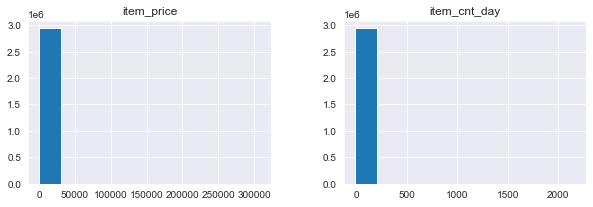

In [28]:
# plot distributions
df_sales[['item_price','item_cnt_day']].hist(figsize=(10, 3))
plt.show()

**_Both features heavily skewed to the right. These could be data collection errors, but further domain knowledge required to determine this._** 

**_Will treat these as outliers and remove._**

### 2.2.2 Seasonality
_Is there seasonality that needs to be taken into account when training a model?_

In [29]:
# new dataframe
df_seasonality = (
    df_sales.copy()
    .set_index('date')
    .groupby([pd.Grouper(freq='M', level='date'), 'date_block_num'])
    .agg(item_cnt_month = ('item_cnt_day', 'sum'))
    .reset_index()
    .set_index('date')
)

df_seasonality.head(3)

,date_block_num,item_cnt_month
date,,
2013-01-31,0,131479.0
2013-02-28,1,128090.0
2013-03-31,2,147142.0


In [30]:
# fit linear model
X = df_seasonality.drop(['item_cnt_month'], axis=1)
y = df_seasonality.item_cnt_month


enet = ElasticNet(random_state=123)
enet.fit(X, y)

ElasticNet(random_state=123)

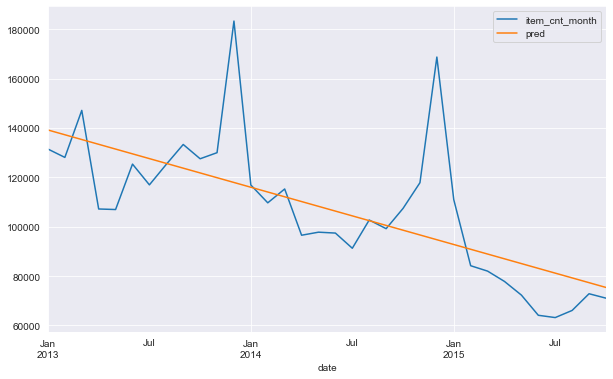

In [31]:
# generate prediction and plot
df_seasonality['pred'] = enet.predict(X)
df_seasonality[['item_cnt_month', 'pred']].plot(figsize=(10, 6))
plt.show()

___Overall decline in sales over time.___

___Huge spikes in December, likely due to holiday season.___

In [32]:
# seasonal features
df_seasonality['xmas'] = [1 if x in (11, 23) else 0 for x in df_seasonality.date_block_num]
df_seasonality['quarter'] = [q for q in df_seasonality.index.quarter]

# X and y variables
X_seasonal = pd.get_dummies(df_seasonality
                            .drop(['item_cnt_month', 'pred'], axis=1), columns=['quarter'], drop_first=True)
y_seasonal = df_seasonality.item_cnt_month

# fit model
enet = ElasticNet(random_state=123)
enet.fit(X_seasonal, y_seasonal)

ElasticNet(random_state=123)

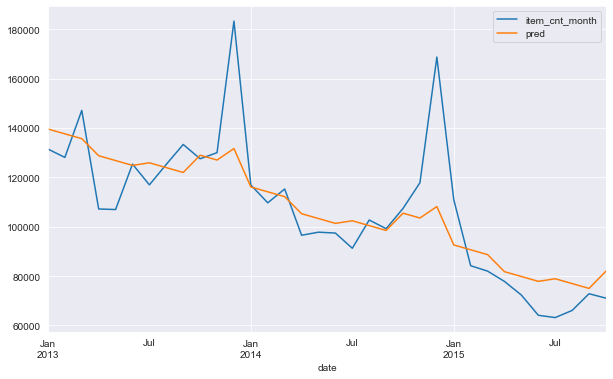

In [33]:
# prediction
df_seasonality['pred'] = enet.predict(X_seasonal)
df_seasonality[['item_cnt_month', 'pred']].plot(figsize=(10, 6))
plt.show()

___Since there is a clear trend over time, the problem could be framed as a time-series problem.___

___Seasonal features could help improve predictive accuracy.___

### 2.2.3 Item lifecycle
- _What is the typical lifecycle of an item?_
    - Is there enough monthly sales history to predict counts?
- _How often are new items introduced?_
- _How do categories develop over time?_

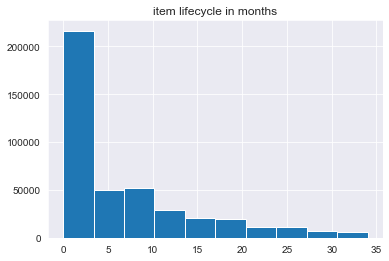

In [34]:
# grouped dataframe
df_sales_lc = (
    df_sales
    .copy()
    .groupby(['shop_id', 'item_id'])
    .agg(date_min= ('date', 'min'),
         date_max= ('date', 'max'),
         item_cnt_day= ('item_cnt_day', 'sum'))
    .assign(diff = lambda x: x.date_max - x.date_min)
    .assign(delta = lambda x: np.round((x.date_max - x.date_min)/np.timedelta64(1, 'M'),0))
    .astype({'delta': 'int'})
    
)

# plot distribution
df_sales_lc['delta'].hist()

plt.title('item lifecycle in months')
plt.show()



___The typical lifecylce of an item is 3 or less months.___

___There could be good 'end-of-life' feature to engineer for the model.___

_How to sales of new items compare with recurring sales?_

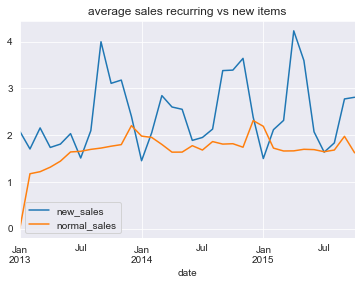

In [35]:
# 1 group sales by month
df_sales_month = (
    df_sales.copy()
    .set_index('date')
    .groupby([pd.Grouper(freq='M', level='date'), 'shop_id', 'item_id'])
    .agg(item_cnt_month = ('item_cnt_day', 'sum'))
    .reset_index()
)

# 2 get first sale of item by shop
df_sales_new_item = (
    df_sales_month.copy()    
    .groupby(['shop_id', 'item_id'])
    .agg(date = ('date', 'min'))
    .assign(item_is_new = 1)
    .reset_index()
)

# 3 merge merge and plot
(
    df_sales_month.copy()
    .merge(df_sales_new_item, how='left', on=['date', 'shop_id', 'item_id'])
    #.fillna(0)
    .assign(new_sales= lambda x: x.item_cnt_month * x.item_is_new,
            normal_sales= lambda x: np.where(x.item_is_new != 1, x.item_cnt_month, 0))
    .groupby('date')
    .agg(new_sales = ('new_sales', 'mean'),
         normal_sales = ('normal_sales', 'mean'))
).plot()

plt.title('average sales recurring vs new items')
plt.show()

___Different behaviour between old and new items. There are potentially two periods in the year when shops make their initial purchase of an item. November is part of this peak.___ 

___Time-series may not be a good precictor of new item sales.___

# 3. Data cleaning and wrangling

1. drop duplicates
2. mask test shops and items
3. mask outliers
4. Summarize to month

## 3.1 Reduce data by shop and item

In [36]:
# mask
test_shops = df_test.shop_id.unique()
test_items = df_test.item_id.unique()
mask_test_shops = df_sales.shop_id.isin(test_shops)
mask_test_items = df_sales.item_id.isin(test_items)

# new dataframe
df_sales_clean = (
    df_sales.copy()[mask_test_shops & mask_test_items]
    .drop_duplicates()
)

print(df_sales_clean.shape)
df_sales_clean.head(3)

(1224434, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
10,2013-01-03,0,25,2574,399.0,2.0
11,2013-01-05,0,25,2574,399.0,1.0


## 3.2 Reduce data by removing outliers

In [37]:
# boundaries
upper_bound = df_sales_clean.quantile(0.99)
lower_bound = df_sales_clean.quantile(0.01)
# upper_bound
lower_bound

date_block_num      0.0
shop_id             2.0
item_id           486.0
item_price          5.0
item_cnt_day        1.0
Name: 0.01, dtype: float64

In [38]:
# boundaries
upper_bound = df_sales_clean.quantile(0.99)
lower_bound = df_sales_clean.quantile(0.01)

# mask
mask_upper = (df_sales_clean.item_cnt_day <= upper_bound.item_cnt_day) & (df_sales_clean.item_price <= upper_bound.item_price)
mask_lower = (df_sales_clean.item_cnt_day >= lower_bound.item_cnt_day) & (df_sales_clean.item_price >= lower_bound.item_price)

# new dataframe
df_sales_clean = (
    df_sales_clean.copy()[mask_upper & mask_lower]
)

print(df_sales_clean.shape)
df_sales_clean.head(3)                            


(1198022, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
10,2013-01-03,0,25,2574,399.0,2.0
11,2013-01-05,0,25,2574,399.0,1.0


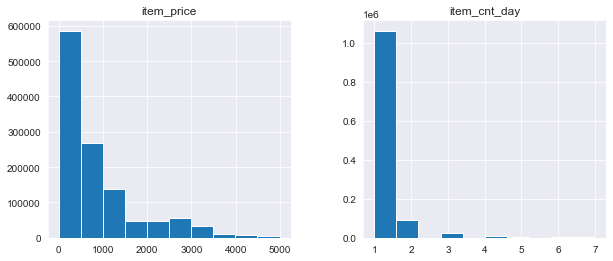

In [39]:
# plot distributions
df_sales_clean[['item_price','item_cnt_day']].hist(figsize=(10, 4))
plt.show()

## 3.3 Group sales by month
The target variable is `item_cnt_month` per month, therefore the train data should be summarized from day to month. The grouper function used and date set to month end.

In [40]:
# new dataframe
df_sales_month = (
    df_sales_clean
    .copy()
    .set_index(['date', 'shop_id', 'item_id'])
    .groupby([pd.Grouper(freq='M', level='date'), 'shop_id', 'item_id'])
    .agg(item_cnt_month = ('item_cnt_day', 'sum'))    
    )


print(df_sales_month.shape)
df_sales_month.head(3)

(594482, 1)


item_cnt_month
date       shop_id item_id                
2013-01-31 2       33                  1.0
                   482                 1.0
                   491                 1.0

## 3.4 Create matrix


The observations should consist of every possible month, shop, item.
- This is because there is no way to know which test data observations are actual sales of items in Nov 2015.
- The model must therefore be trained to predict
    - Recurring sales
    - Sales of new items
    - No sales


In [41]:
# get combinations of dates, shops, items
df_sales_matrix = (
    df_sales_month
    .copy()
    .unstack(level=[0,1])
    .fillna(0)
    .stack(['shop_id', 'date'])
    .reset_index()
)

print(df_sales_matrix.shape)
df_sales_matrix.tail(3)

(6182493, 4)


,item_id,shop_id,date,item_cnt_month
6182490,22167,59,2015-08-31,0.0
6182491,22167,59,2015-09-30,0.0
6182492,22167,59,2015-10-31,0.0


___`df_sales_matrix` is created. Now on to feature engineering.___

# 4. Feature engineering

This section will generate an analytical base table (ABT). This will consist of the following feature columns:

- Time-series 
The goal here is to prepare a table of time series features. Since these features are based on lags, the table must be indexed by date only. The values can be shifted across the date index once the dataframe has been reshaped by pivoting. Multiple dateframes containing various lag features will be concatenated together then rehshaped back top the original, flat structure. 


- Binary lifecycle
Binary features will be applied to the dataframe which indicate if an item is start or end of life.


- Seasonal features
Seasonal features will be omitted from this version and revisited at a later stage (see 'next steps')



A pandas pipeline will prepare the ABT as follows:
1. reshape
2. generate lags
3. reshape
4. lifecyle
5. item category mean
6. clean up

## 4.1 Reshape

In [45]:
def reshape_by_pivot(df):
    """
    creates the base dataframe from which to copy and shift values for lags
    """
    return (
    df
    .assign(target=lambda x: x.item_cnt_month)
    .pivot_table(index=['shop_id', 'item_id'], columns='date', values=['item_cnt_month', 'target'])
    .fillna(0)
    )

## 4.2 Add lag features

In [48]:
def add_lag_features(df):
    """
    creates new dataframes with lags then concatenates them together
    """
    df_shift1 = df[['item_cnt_month']].rename({'item_cnt_month': 'shift1'}, axis=1).shift(1, axis=1, fill_value=0)
    df_shift2 = df[['item_cnt_month']].rename({'item_cnt_month': 'shift2'}, axis=1).shift(2, axis=1, fill_value=0)
    df_shift3 = df[['item_cnt_month']].rename({'item_cnt_month': 'shift3'}, axis=1).shift(3, axis=1, fill_value=0)

    df_rolling2 = df_shift1.rename({'shift1': 'rolling2'}, axis=1).rolling(window=2, axis=1).mean()
    df_rolling3 = df_shift1.rename({'shift1': 'rolling3'}, axis=1).rolling(window=3, axis=1).mean()

    # not used for training
    df_rolling2_new = df[['item_cnt_month']].rename({'item_cnt_month': 'rolling2_new'}, axis=1).rolling(window=2, axis=1).mean()
    df_rolling3_new = df[['item_cnt_month']].rename({'item_cnt_month': 'rolling3_new'}, axis=1).rolling(window=3, axis=1).mean() 
    
    return (
            pd.concat([df, df_shift1, df_shift2, df_shift3,
               df_rolling2, df_rolling3, 
               df_rolling2_new, df_rolling3_new                
              ], axis=1)
            )


## 4.3 Reshape by stacking

In [50]:
def reshape_by_stack(df):
    """
    reshapes the data back to it's original structure then indexes by date
    """
    return (
        df
        .stack(level=[1])
        .fillna(0)
        .reset_index()
        .sort_values(['date', 'shop_id', 'item_id'])
        .set_index('date')    
    )
    

## 4.4 Add lifecycle features

In [130]:
def add_lifecycle_features(df):
    """
    1. store min/max dates per item to dictionary
    2. map min/max dates to dataframe
    3. add binary lifecycle features
    """
    
    # empty dicts
    dict_item_start = {}
    dict_item_end = {}

    # temp dataframe containing only item_id and date
    temp_df_sales_month = (
        df
        .reset_index()[['date', 'item_id']]
    )

    # loop over dataframe to populate dicts
    for i in temp_df_sales_month.item_id.sort_values().unique():
        mask = temp_df_sales_month.item_id == i
        dict_item_start[i] = min(temp_df_sales_month[mask].date) + pd.tseries.offsets.MonthEnd(0)
        dict_item_end[i] = max(temp_df_sales_month[mask].date) + pd.tseries.offsets.MonthEnd(0)
        
    return (
        df
        .reset_index()
        .assign(item_start = lambda x: x.item_id.map(dict_item_start))
        .assign(item_end = lambda x: x.item_id.map(dict_item_end))    
        .assign(startoflife = lambda x: np.where(x.date == x.item_start, 1, 0))
        .assign(endoflife = lambda x: np.where(x.date >= x.item_end + pd.tseries.offsets.MonthEnd(3), 1, 0))
        .set_index('date')
           )

## 4.5 Add item category mean features

In [62]:
def add_item_category_mean_features(df):
    """
    1. map item category ids to items
    2. assign mean features based on category group
    3. weight the results by shop sales of previous month
    """
    
    # item_id, item_category_id to dict
    dict_item_category = df_item[['item_id', 'item_category_id']].set_index('item_id').to_dict()['item_category_id']

    # map item_category to abt_base
    df['item_category_id'] = df.item_id.map(dict_item_category)
    
    return (
        df
        .reset_index()
        # mean calculations
        .assign(shift1_cat_mean = lambda x: x.groupby(['date', 'shop_id', 'item_category_id'])['shift1'].transform('mean'))
        .assign(rolling3_cat_mean = lambda x: x.groupby(['date', 'shop_id', 'item_category_id'])['rolling3'].transform('mean'))
        # shop weight calculation
        .assign(shift1_shop_total = lambda x: x.groupby(['date', 'shop_id'])['shift1'].transform('sum'))
        .assign(shift1_month_total = lambda x: x.groupby(['date'])['shift1'].transform('sum'))
        .assign(shop_weight = lambda x: x.shift1_shop_total / x.shift1_month_total)
        # weighted means
        .assign(item_cat_mean_shift1_weighted = lambda x: x.shift1_cat_mean * x.shop_weight)
        .assign(item_cat_mean_rolling3_weighted = lambda x: x.rolling3_cat_mean * x.shop_weight)        
        .set_index('date')
    )
    
    

## 4.6 ABT clean up

In [80]:
def abt_cleanup(df):
    """
    1. drop unwanted feature columns
    2. fill nulls
    3. sort columns axis
    """
    column_list = ['item_category_id', 'item_cnt_month', 'item_start', 'item_end',
                   'shift1_cat_mean', 'rolling3_cat_mean', 'shift1_shop_total', 'shift1_month_total', 'shop_weight']
    
    return (
        df
        .drop(column_list, axis=1)
        .fillna(0)
        .sort_index(axis=1)
    )

## 4.7 ABT pipeline

In [81]:
# pandas pipeline to build analytical base table (ABT)
abt = (
    df_sales_matrix
    .copy()
    .pipe(reshape_by_pivot)
    .pipe(add_lag_features)
    .pipe(reshape_by_stack)
    .pipe(add_lifecycle_features)
    .pipe(add_item_category_mean_features)
    .pipe(abt_cleanup)
)

print(abt.shape)
abt.tail(3)


(6653052, 14)


,endoflife,item_cat_mean_rolling3_weighted,item_cat_mean_shift1_weighted,item_id,rolling2,rolling2_new,rolling3,rolling3_new,shift1,shift2,shift3,shop_id,startoflife,target
date,,,,,,,,,,,,,,
2015-10-31,0,0.002002,0.001826,22164,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,59,0,0.0
2015-10-31,0,0.000000,0.000000,22166,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,59,0,0.0
2015-10-31,0,0.000532,0.000399,22167,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,59,0,0.0


# 5. Machine Learning
This time series problem will be framed in a way that train-test sets are split over consecutive periods. 

This training a model on all periods is resource intensive, therefore, for this iteration, the training period will be reduced. Reducing the training period in this way will also eliminate the seasonality element (holiday season) which would overcomplicate the model for the Nov 2015 prediction.

A custom cross-validation method is required to fold the train set on specific months. 

The steps are as follows:

1. set scope
    - test period is latest month (Oct 2015)
    - train period limited to 5 months prior
2. X, y variables
    - `X = abt.drop(['shop_id', 'item_id', 'target'], axis=1)`
    - `y = abt_ts.target`
3. cross-validation prep
    - 4 folds on the 5 month train set
4. model pipelines
    - StandardScaler
    - ElasticNet, RandomForest, GradientBooster
5. metrics
    - Root mean squared error (RMSE)

## 5.1 Train and test splits
Define the train and test date ranges.


In [82]:
test_period = abt.index[-1]
train_start = abt.index[-1] + pd.tseries.offsets.MonthEnd(-5)
train_end = test_period + pd.tseries.offsets.MonthEnd(-1)
train_period = pd.date_range(start=train_start, 
                                end=train_end
                                 , freq='M')

print('train:', train_period)
print('test:', test_period)

train: DatetimeIndex(['2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30'],
              dtype='datetime64[ns]', freq='M')
test: 2015-10-31 00:00:00


Define X and y variables and split into train and test

In [83]:
X = abt.drop(['shop_id', 'item_id', 'target', 'rolling2_new','rolling3_new'], axis=1)
y = abt.target

X_train = X.loc[(train_period)]
y_train = y.loc[(train_period)]

# X_test, y_test for scoring metrics
X_test = X.loc[(test_period)]
y_test = y.loc[(test_period)]

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train.head(3)

X_train (978390, 9)
y_train (978390,)
X_test (195678, 9)
y_test (195678,)


,endoflife,item_cat_mean_rolling3_weighted,item_cat_mean_shift1_weighted,rolling2,rolling3,shift1,shift2,shift3,startoflife
date,,,,,,,,,
2015-05-31,0,0.000725,0.000877,0.0,0.000000,0.0,0.0,0.0,0
2015-05-31,0,0.000698,0.000860,0.0,0.000000,0.0,0.0,0.0,0
2015-05-31,0,0.000725,0.000877,0.5,0.333333,0.0,1.0,0.0,0


## 5.2 Define custom cross validation folds for time-series (tscv)

The objective is to create a list of index ranges that can be input to the GridSearch parameters.

For traditional machine learning problems, we randomly select subsets of data for the validation and test sets. But in this time-sensitive case, each data point is dependent on its past values. If we randomly shuffle the data, we might be training on future data and predicting the past values. It is therefore important that we carefully build a validation set when working on a time series problem, without destroying the sequential order within the data.

### 5.2.1 store test indexes

In [84]:
test_idxs = {}
cv_test_period = train_end

for i in range(1, 5):
    test_idxs[i] = list(range(y_train.index.get_loc(cv_test_period).start, 
                                   y_train.index.get_loc(cv_test_period).stop))
    print(cv_test_period)
    cv_test_period += pd.tseries.offsets.MonthEnd(-1)   

2015-09-30 00:00:00
2015-08-31 00:00:00
2015-07-31 00:00:00
2015-06-30 00:00:00


### 5.2.2 store train indexes

In [85]:
train_idxs = {}
cv_train_start = X_train.index[0]
cv_train_end = train_end + pd.tseries.offsets.MonthEnd(-1)

for i in range(1, 5):
    cv_train_range = pd.date_range(start=cv_train_start, end=cv_train_end, freq='M')

    train_idxs[i] = list(range(X_train.index.get_loc(cv_train_range[0]).start, 
                                       X_train.index.get_loc(cv_train_range[-1]).stop
                                   ))
    print(f'split{i}:', cv_train_range)
    cv_train_end += pd.tseries.offsets.MonthEnd(-1)


split1: DatetimeIndex(['2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31'], dtype='datetime64[ns]', freq='M')
split2: DatetimeIndex(['2015-05-31', '2015-06-30', '2015-07-31'], dtype='datetime64[ns]', freq='M')
split3: DatetimeIndex(['2015-05-31', '2015-06-30'], dtype='datetime64[ns]', freq='M')
split4: DatetimeIndex(['2015-05-31'], dtype='datetime64[ns]', freq='M')


### 5.2.3 verify index ranges

In [86]:
# check the indexes of the cross validation sets
print(train_idxs[1][0], train_idxs[1][-1], '..', test_idxs[1][0], test_idxs[1][-1])
print(train_idxs[2][0], train_idxs[2][-1], '..', test_idxs[2][0], test_idxs[2][-1])
print(train_idxs[3][0], train_idxs[3][-1], '..', test_idxs[3][0], test_idxs[3][-1])
print(train_idxs[4][0], train_idxs[4][-1], '..', test_idxs[4][0], test_idxs[4][-1])

0 782711 .. 782712 978389
0 587033 .. 587034 782711
0 391355 .. 391356 587033
0 195677 .. 195678 391355


### 5.2.4 store to list

In [87]:
tscv = [
 (train_idxs[1], test_idxs[1]),
 (train_idxs[2], test_idxs[2]),
 (train_idxs[3], test_idxs[3]),
 (train_idxs[4], test_idxs[4])
]

## 5.3 Pipelines

In [92]:
# Create pipelines dictionary
pipelines = {
    #'enet': make_pipeline(StandardScaler(), ElasticNet(random_state=123)),
    #'rf' : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
    
                         }         

## 5.4 Hyperparameters

In [93]:
# Elastic Net hyperparameters
enet_hyperparameters = { 
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1, 5, 10],                        
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Random forest hyperparameters
rf_hyperparameters = { 
    'randomforestregressor__n_estimators' : [50, 100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33],
    'randomforestregressor__min_samples_leaf': [1, 3, 5]
}

# Boosted tree hyperparameters
gb_hyperparameters = { 
    #'gradientboostingregressor__n_estimators': [100, 200],
    #'gradientboostingregressor__learning_rate' : [0.05, 0.1, 0.2],
    #'gradientboostingregressor__max_depth': [1, 3, 5]
    'gradientboostingregressor__n_estimators': [100],
    'gradientboostingregressor__learning_rate' : [0.1],
    'gradientboostingregressor__max_depth': [3]    
}

In [94]:
# Create hyperparameters dictionary
hyperparameters = {
    'enet' : enet_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

## 5.5 Fit and store models

In [95]:
# empty dict to later store fitted models
fitted_models = {}

# loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # initialize grid
    model = GridSearchCV(pipeline, hyperparameters[name], cv=tscv, n_jobs=-1)
    
    # fit model
    model.fit(X_train, y_train)
    
    # store fitted model
    fitted_models[name] = model
    
    # print
    print(name, 'has been fitted.')

gb has been fitted.


## 5.6 Evaluate models

In [96]:
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name)
    print('----------' )
    print('cv score :', model.best_score_)
    print('RMSE     :', mean_squared_error(y_test, pred, squared=False))
    print()

gb
----------
cv score : 0.5559304682948603
RMSE     : 0.9551704311974707



___The gradient performs best as indicated by both the cross validation score and the Root Mean Square Error (RMSE)___

In [154]:
# examine the parameters of the best estimator
from sklearn import set_config
set_config(print_changed_only=False)
fitted_models['gb'].best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=N

## 5.7 Save best model (estimator)

In [125]:
# save the best esimator
with open('model_ts.pkl', 'wb') as f:
    pickle.dump(fitted_models['gb'].best_estimator_, f)

## 5.8 Feature importance

In [97]:
# Helper function for plotting feature importances
def plot_feature_importances(columns, feature_importances, show_top_n=10):
    feats = dict( zip(columns, feature_importances) )
    global imp
    imp = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    imp.sort_values(by='Gini-importance').tail(show_top_n).plot(kind='barh', figsize=(8,8))
    plt.show()


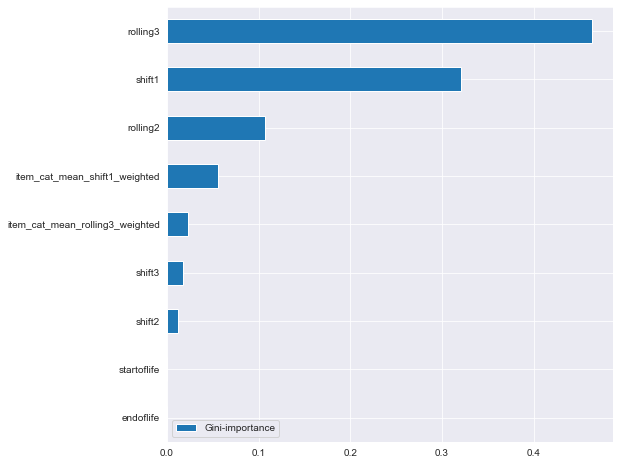

In [98]:
plot_feature_importances(X_train.columns, fitted_models['gb'].best_estimator_[1].feature_importances_)

___The less important features could be removed to reduce model complexity.___

# 6. New data
The test data set will be loaded and prepared to meet the input requirements of the fitted model. The time series features can be reused from the abt dataframe. The lifecycle and item category mean features will be calculated. 

Finally, the submission data will be prepared to be uploaded to kaggle.


## 6.1 Shift time-series features

In [109]:
abt_cols_to_keep = ['shop_id', 'item_id', 'target', 
                    'rolling2_new', 'rolling3_new', 'shift1', 'shift2']

abt_cols_to_rename = ['shop_id', 'item_id', 'shift1', 
                    'rolling2', 'rolling3', 'shift2', 'shift3']

# keep time-series columns
new_ts = abt.copy()[abt_cols_to_keep]
# rename 
new_ts.columns = abt_cols_to_rename

# update date index
new_ts.index = new_ts.index + pd.tseries.offsets.MonthEnd(1)
new_ts.reset_index(inplace=True)
new_ts.tail(3)


,date,shop_id,item_id,shift1,rolling2,rolling3,shift2,shift3
6653049,2015-11-30,59,22164,0.0,0.0,0.0,0.0,0.0
6653050,2015-11-30,59,22166,0.0,0.0,0.0,0.0,0.0
6653051,2015-11-30,59,22167,0.0,0.0,0.0,0.0,0.0


In [117]:
def merge_time_series(df):
    """
    merge the time series data frame with the test data
    """
    return (
        df
        .merge(new_ts,on=['shop_id', 'item_id'], how='left')
        .fillna({'date' : pd.Timestamp('2015-11-30')})
        .set_index('date')
    )

## 6.2 New ABT pipeline

In [123]:
def clean_up_new_data(df):
    """
    1. drop unwanted columns
    2. filter only for Nov 2015 with test ids
    3. fill nulls
    4. set date index
    5. sort column axis
    """
    column_list = ['item_category_id', 'item_start', 'item_end',
                   'shift1_cat_mean', 'rolling3_cat_mean', 'shift1_shop_total', 'shift1_month_total', 'shop_weight']
    
    return (
        df
        .reset_index()
        .drop(column_list, axis=1)
        .sort_values(['date','shop_id', 'item_id'])
        .query("date == '2015-11-30' & ID >= 0")
        .fillna({'startoflife': 1,
                 'endoflife': 0})
        .fillna(0)
        .set_index('date')
        .sort_index(axis=1)
        .astype({'ID': int})    
    )

In [122]:
# pandas pipeline for new data ABT
abt_new = (
    df_test
    .copy()
    .pipe(merge_time_series)
    .pipe(add_lifecycle_features)
    .pipe(add_item_category_mean_features)
    .pipe(clean_up_new_data)
)

print(abt_new.shape)
abt_new.tail(3)

(214200, 12)


,ID,endoflife,item_cat_mean_rolling3_weighted,item_cat_mean_shift1_weighted,item_id,rolling2,rolling3,shift1,shift2,shift3,shop_id,startoflife
date,,,,,,,,,,,,
2015-11-30,149242,0,0.001955,0.002329,22164,0.0,0.0,0.0,0.0,0.0,59,0
2015-11-30,152328,0,0.000000,0.000000,22166,0.0,0.0,0.0,0.0,0.0,59,0
2015-11-30,148377,0,0.000345,0.000173,22167,0.0,0.0,0.0,0.0,0.0,59,0


## 6.3 Import model and generate prediction

In [126]:
#import model
model_ts = pickle.load( open( 'model_ts.pkl', 'rb') )
model_ts

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=123))])

In [127]:
# new column
abt_new['item_cnt_month'] = np.round(model_ts
                                     .predict(abt_new.drop(['shop_id', 'item_id', 'ID'], axis=1))
                                     .clip(0, 20),1)
abt_new.tail(3)

,ID,endoflife,item_cat_mean_rolling3_weighted,item_cat_mean_shift1_weighted,item_id,rolling2,rolling3,shift1,shift2,shift3,shop_id,startoflife,item_cnt_month
date,,,,,,,,,,,,,
2015-11-30,149242,0,0.001955,0.002329,22164,0.0,0.0,0.0,0.0,0.0,59,0,0.1
2015-11-30,152328,0,0.000000,0.000000,22166,0.0,0.0,0.0,0.0,0.0,59,0,0.0
2015-11-30,148377,0,0.000345,0.000173,22167,0.0,0.0,0.0,0.0,0.0,59,0,0.0


## 6.4 Create kaggle submission file

In [128]:
df_submission = (
    abt_new[['ID', 'item_cnt_month']]
    .copy()
    .reset_index()
    .drop(['date'], axis=1)
    .set_index('ID')
    .sort_index()
)

df_submission    

,item_cnt_month
ID,
0,0.7
1,0.1
2,1.0
3,0.3
4,0.3
...,...
214195,0.2
214196,0.1
214197,0.1


In [129]:
# dataframe to csv
df_submission.to_csv('submission.csv', index=True)

# 7. Insights and next steps

### Winning model
The winning model was a gradient boosting regressor.
- cv score : 0.56
- RMSE     : 0.96

### Kaggle result
- Score : **RMSE 1.01**
- Postition: **4611 /10179 (45%)**

The current leading score is 0.75 RMSE. I'm pleased as a beginner to break into the top 50, however I would like to improve on this score in future iterations.

### Reflection
There were several challenges in this project. The volume of train data was an issue and I suffered from kernel restarts when preparing the time series matrix. Reducing the data to only the shops used in the train data helped, however the issue remaining when it came to model training with hyperparameter tuning. Further reducing the set to train on only items in the test set helped. The cross-validation score decreased, but the kaggle score was unaffected.

Another major challenge was how to interpret the test data. Why were select sets of shops and items included? In the real world, the item lifecycle would help determine which shops and items you need to predict the sales of. The training data could be adjusted to reflect this. 


### Next steps
- Data cleaning
    - clip outliers rather than removing them
- Feature engineering
    - Principale Component Analysis on shops with the top variance
- Hyperparameter tuning
    - the gradient boosting regressor is known for high performance with extensive tuning. More research into the tuning possibilities should improve performace.
- Classifier
    - classifying shops into groups that buy specific items at a certain time.
- Post-processing
    - analyze which shops perform poorest after model training and action


